# 02: Positional Encoding

*Giving the amoeba a sense of where.*

---

In notebook 01, our bag-of-words model treated input as an unordered set. "The dog bit the girl" and "The girl bit the dog" produced identical predictions. That's a fundamental limitation.

Now we add **positional embeddings**—a second embedding table that encodes *where* each token appears, not just *what* it is.

**The change:**
```
Before: embedding = W_token[token_id]
After:  embedding = W_token[token_id] + W_pos[position]
```

That's it. One addition. But now the model knows that position 0 is different from position 5, and can learn patterns like "the word after 'named' is usually a name."

**What we expect:** Better than the amoeba, but still limited. The model knows *where* tokens are, but tokens still can't *see* each other—there's no attention yet. It's like knowing you're in seat 5 of a theater but having a blindfold on.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Load Data and Tokenizer

Same data as notebook 01. The only thing changing is the model architecture.

In [2]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy (copied from notebook 00)."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def decode_single(self, token_id):
        """Decode a single token ID to its string representation."""
        if token_id == self.pad_id:
            return '<pad>'
        if token_id == self.unk_id:
            return '<unk>'
        if token_id == self.eos_id:
            return '<eos>'
        if token_id in self.compact_to_gpt2:
            return self.gpt2_tokenizer.decode([self.compact_to_gpt2[token_id]])
        return '<???>'  
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


# Load tokenizer
tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [3]:
# Load pre-tokenized sequences
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. Model Architecture

### What Are Learned Positional Embeddings?

Just like we have an embedding table for tokens:
- `W_token`: shape `[vocab_size, d_model]` — row *i* is the embedding for token *i*

We add an embedding table for positions:
- `W_pos`: shape `[max_seq_len, d_model]` — row *i* is the embedding for position *i*

The model *learns* what each position means during training. Position 0 might learn "I'm the beginning of a sentence." Position 7 might learn "I'm often where names appear after 'named'." These aren't programmed—they emerge from the data.

### Why Addition?

We combine token and position embeddings by adding them:
```
embedding = W_token[token_id] + W_pos[position]
```

Why not concatenation? Addition keeps the dimension the same (d_model), so downstream layers don't need to change. It's also what GPT-2, GPT-3, and most modern transformers do.

Intuitively: the token embedding says "what I am" and the position embedding adds "where I am" as a modifier.

### The Full Architecture

```
Input [batch, seq_len]
    → Token embedding [batch, seq_len, d_model]
    → + Position embedding [batch, seq_len, d_model]
    → Mean over seq_len [batch, d_model]
    → Linear [batch, vocab_size]
```

Same as notebook 01, just with position embeddings added before averaging.

In [4]:
class PositionalBagOfWordsLM(nn.Module):
    """
    Bag of words + positional embeddings.
    
    Architecture:
        Input [batch, seq_len] 
        → Token Embedding [batch, seq_len, d_model]
        → + Position Embedding [batch, seq_len, d_model]
        → Mean [batch, d_model]
        → Linear [batch, vocab_size]
    
    The only difference from notebook 01 is the position embedding addition.
    """
    
    def __init__(self, vocab_size, d_model, max_seq_len):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # Token embedding: token ID → vector
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Position embedding: position index → vector
        # This is the NEW part!
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Output projection: vector → logits over vocabulary
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        """
        Args:
            x: Input token IDs, shape [batch, seq_len]
        
        Returns:
            logits: Shape [batch, vocab_size]
        """
        batch_size, seq_len = x.shape
        
        # Token embeddings: [batch, seq_len, d_model]
        tok_emb = self.token_embedding(x)
        
        # Position indices: [0, 1, 2, ..., seq_len-1]
        positions = torch.arange(seq_len, device=x.device)
        
        # Position embeddings: [seq_len, d_model] → broadcast to [batch, seq_len, d_model]
        pos_emb = self.position_embedding(positions)
        
        # Combine: token + position
        # This is the key line! Now each token knows where it is.
        embedded = tok_emb + pos_emb
        
        # Average over sequence: [batch, seq_len, d_model] → [batch, d_model]
        pooled = embedded.mean(dim=1)
        
        # Project to vocabulary: [batch, d_model] → [batch, vocab_size]
        logits = self.unembed(pooled)
        
        return logits
    
    def generate(self, prompt_tokens, max_new_tokens=20):
        """
        Generate tokens autoregressively.
        
        Args:
            prompt_tokens: List of token IDs
            max_new_tokens: How many tokens to generate
        
        Returns:
            List of generated token IDs (not including prompt)
        """
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Truncate to max_seq_len if needed
                input_tokens = tokens[-self.max_seq_len:]
                x = torch.tensor([input_tokens], device=next(self.parameters()).device)
                
                # Get prediction
                logits = self.forward(x)
                probs = F.softmax(logits, dim=-1)
                
                # Sample from distribution
                next_token = torch.multinomial(probs[0], num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                # Stop at EOS
                if next_token == 2:  # EOS
                    break
        
        return generated

In [5]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128                # Embedding dimension (same as notebook 01)
MAX_SEQ_LEN = 256            # Maximum sequence length (matches our data)

# Create model
model = PositionalBagOfWordsLM(VOCAB_SIZE, D_MODEL, MAX_SEQ_LEN).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")
print(f"  Token embedding:    {VOCAB_SIZE} × {D_MODEL} = {VOCAB_SIZE * D_MODEL:,}")
print(f"  Position embedding: {MAX_SEQ_LEN} × {D_MODEL} = {MAX_SEQ_LEN * D_MODEL:,}  ← NEW!")
print(f"  Unembed:            {D_MODEL} × {VOCAB_SIZE} + {VOCAB_SIZE} = {D_MODEL * VOCAB_SIZE + VOCAB_SIZE:,}")
print(f"")
print(f"Notebook 01 had: 1,052,672 parameters")
print(f"Notebook 02 has: {num_params:,} parameters (+{num_params - 1052672:,} for positions)")

Model parameters: 1,085,440
  Token embedding:    4096 × 128 = 524,288
  Position embedding: 256 × 128 = 32,768  ← NEW!
  Unembed:            128 × 4096 + 4096 = 528,384

Notebook 01 had: 1,052,672 parameters
Notebook 02 has: 1,085,440 parameters (+32,768 for positions)


---

## 3. Training Setup

Same hyperparameters as notebook 01 for fair comparison.

In [6]:
# === Training Parameters ===
# (Same as notebook 01 for fair comparison)
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
NUM_EPOCHS = 3
EVAL_EVERY = 1000

def make_batch(data, batch_indices):
    """Create a training batch."""
    sequences = data[batch_indices]
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)
    y = torch.tensor(sequences[:, -1], dtype=torch.long, device=device)
    return x, y


# Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Calculate total steps
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")

Steps per epoch: 7,232
Total steps: 21,696


In [7]:
def evaluate(model, data, num_batches=50):
    """Evaluate model on a subset of data."""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            logits = model(x)
            loss = criterion(logits, y)
            
            total_loss += loss.item() * len(y)
            predictions = logits.argmax(dim=-1)
            total_correct += (predictions == y).sum().item()
            total_samples += len(y)
    
    model.train()
    return {
        'loss': total_loss / total_samples,
        'accuracy': total_correct / total_samples,
        'perplexity': math.exp(total_loss / total_samples)
    }

---

## 4. Training Loop

In [8]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_perplexity': []
}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    perm = np.random.permutation(len(train_data))
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step += 1
        
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_accuracy'].append(val_metrics['accuracy'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/3:   0%|          | 0/7232 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/7232 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/7232 [00:00<?, ?it/s]


Training complete!


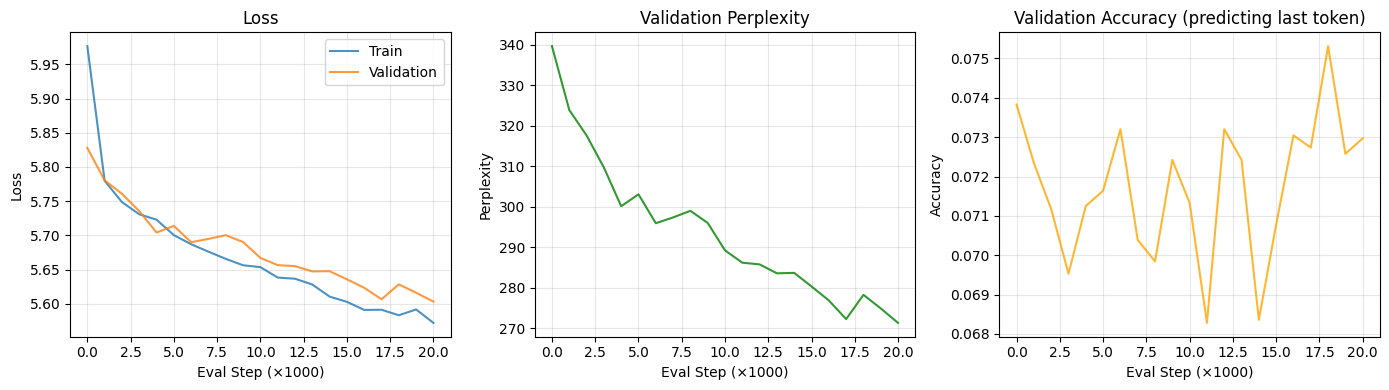


Final validation loss: 5.603
Final validation perplexity: 271.3
Final validation accuracy: 7.30%


In [9]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel('Eval Step (×1000)')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity
axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel('Eval Step (×1000)')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

# Accuracy
axes[2].plot(history['val_accuracy'], color='orange', alpha=0.8)
axes[2].set_xlabel('Eval Step (×1000)')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Validation Accuracy (predicting last token)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")
print(f"Final validation accuracy: {history['val_accuracy'][-1]:.2%}")

---

## 5. Comparison with Notebook 01

Let's see if positional encoding actually helped.

In [10]:
# Load notebook 01 results for comparison
checkpoint_01 = torch.load('01_bag_of_words.pt', map_location='cpu', weights_only=False)
history_01 = checkpoint_01['history']

print("=" * 60)
print("COMPARISON: Notebook 01 vs 02")
print("=" * 60)
print(f"")
print(f"{'Metric':<25} {'01 (No Position)':<20} {'02 (+ Position)'}")
print(f"-" * 60)
print(f"{'Final val loss':<25} {history_01['val_loss'][-1]:<20.3f} {history['val_loss'][-1]:.3f}")
print(f"{'Final val perplexity':<25} {history_01['val_perplexity'][-1]:<20.1f} {history['val_perplexity'][-1]:.1f}")
print(f"{'Final val accuracy':<25} {history_01['val_accuracy'][-1]*100:<20.2f}% {history['val_accuracy'][-1]*100:.2f}%")
print(f"")
print(f"Loss improvement: {history_01['val_loss'][-1] - history['val_loss'][-1]:.3f}")
print(f"Perplexity improvement: {history_01['val_perplexity'][-1] - history['val_perplexity'][-1]:.1f}")

COMPARISON: Notebook 01 vs 02

Metric                    01 (No Position)     02 (+ Position)
------------------------------------------------------------
Final val loss            5.601                5.603
Final val perplexity      270.8                271.3
Final val accuracy        7.33                % 7.30%

Loss improvement: -0.002
Perplexity improvement: -0.5


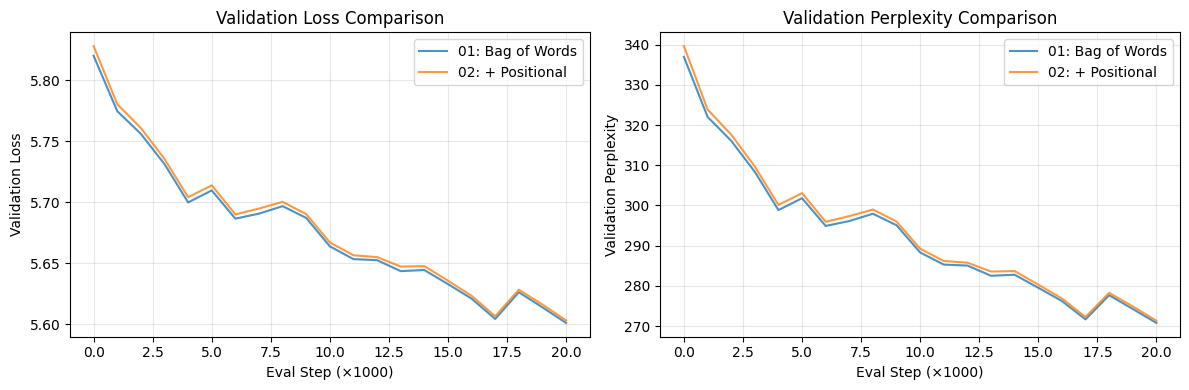

In [11]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss comparison
axes[0].plot(history_01['val_loss'], label='01: Bag of Words', alpha=0.8)
axes[0].plot(history['val_loss'], label='02: + Positional', alpha=0.8)
axes[0].set_xlabel('Eval Step (×1000)')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Validation Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity comparison
axes[1].plot(history_01['val_perplexity'], label='01: Bag of Words', alpha=0.8)
axes[1].plot(history['val_perplexity'], label='02: + Positional', alpha=0.8)
axes[1].set_xlabel('Eval Step (×1000)')
axes[1].set_ylabel('Validation Perplexity')
axes[1].set_title('Validation Perplexity Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---

## 6. Generation: The Moment of Truth

Does knowing position help with generation?

In [12]:
def generate_and_print(prompt, max_tokens=30):
    """Generate from a prompt and print results."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens)
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()
    
    return generated_tokens


print("=" * 60)
print("THE MOMENT OF TRUTH (with positions!)")
print("=" * 60)
print()

# The big test
_ = generate_and_print("Once upon a time there was a girl named")

THE MOMENT OF TRUTH (with positions!)

Prompt: Once upon a time there was a girl named
Generated:  One One Suddenly Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet



In [13]:
# More tests
test_prompts = [
    "Once upon a time",
    "The little girl",
    "He was very",
    "She went to the",
    "They played with",
]

print("More generations:")
print("-" * 60)
for prompt in test_prompts:
    _ = generate_and_print(prompt, max_tokens=20)

More generations:
------------------------------------------------------------
Prompt: Once upon a time
Generated:  there named named One OneAs Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet Tweet

Prompt: The little girl
Generated:  girl her she girl her her her her her her her Her her herHereddyeddyeddyeddyeddy

Prompt: He was very
Generated:  excited. it. He He He He He him he his him he him his him his him him

Prompt: She went to the
Generated:  park park park park dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog

Prompt: They played with
Generated:  time namediskisk Whiskiskiskiskiskiskiskiskiskiskiskiskiskiskisk



In [14]:
def show_top_predictions(prompt, k=10):
    """Show the model's top-k predictions for what comes next."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    x = torch.tensor([prompt_tokens], device=device)
    
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=-1)[0]
    
    top_probs, top_indices = probs.topk(k)
    
    print(f"Prompt: '{prompt}'")
    print(f"Top {k} predictions:")
    for prob, idx in zip(top_probs, top_indices):
        token_str = tokenizer.decode_single(idx.item())
        print(f"  {prob.item():.3f}: {repr(token_str)}")
    print()


print("=" * 60)
print("TOP PREDICTIONS ANALYSIS")
print("=" * 60)
print()

show_top_predictions("Once upon a time there was a girl named")
show_top_predictions("Once upon a time")
show_top_predictions("The dog")

TOP PREDICTIONS ANALYSIS

Prompt: 'Once upon a time there was a girl named'
Top 10 predictions:
  0.870: ' One'
  0.129: ' named'
  0.000: ' loved'
  0.000: ' lived'
  0.000: ' girl'
  0.000: ' years'
  0.000: ' day'
  0.000: ' Every'
  0.000: ' little'
  0.000: 'One'

Prompt: 'Once upon a time'
Top 10 predictions:
  0.839: ' there'
  0.161: ' named'
  0.000: ' time'
  0.000: ' One'
  0.000: ' upon'
  0.000: ' loved'
  0.000: ' lived'
  0.000: ' little'
  0.000: ' girl'
  0.000: ' a'

Prompt: 'The dog'
Top 10 predictions:
  1.000: ' dog'
  0.000: ' owner'
  0.000: 'agged'
  0.000: ' tail'
  0.000: ' w'
  0.000: ' bark'
  0.000: 'icks'
  0.000: ' Spot'
  0.000: ' bone'
  0.000: ' boy'



---

## 7. Position Blindness Test: Is It Fixed?

In notebook 01, "The girl saw the dog" and "The dog saw the girl" gave identical predictions. Does position encoding fix this?

In [15]:
prompts_same_words = [
    "The girl saw the dog",
    "The dog saw the girl",
]

print("Position awareness test:")
print("(These have the same words but different order)")
print("-" * 60)

for prompt in prompts_same_words:
    show_top_predictions(prompt, k=5)

Position awareness test:
(These have the same words but different order)
------------------------------------------------------------
Prompt: 'The girl saw the dog'
Top 5 predictions:
  0.978: ' dog'
  0.004: ' tree'
  0.002: '.'
  0.002: ' the'
  0.002: ' man'

Prompt: 'The dog saw the girl'
Top 5 predictions:
  0.978: ' dog'
  0.004: ' tree'
  0.002: '.'
  0.002: ' the'
  0.002: ' man'



---

## 8. Visualizing the Position Embeddings

What did the model learn about positions? Let's look at the embeddings.

In [16]:
# Get position embeddings
pos_emb = model.position_embedding.weight.detach().cpu().numpy()  # [max_seq_len, d_model]

print(f"Position embedding shape: {pos_emb.shape}")
print(f"")

# Compute cosine similarity between positions
from numpy.linalg import norm

def cosine_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

# Compare a few positions
print("Cosine similarity between position embeddings:")
print("-" * 40)
positions_to_compare = [0, 1, 2, 10, 50, 100, 200, 254]

print(f"Position 0 vs 1:   {cosine_sim(pos_emb[0], pos_emb[1]):.3f}")
print(f"Position 0 vs 2:   {cosine_sim(pos_emb[0], pos_emb[2]):.3f}")
print(f"Position 0 vs 10:  {cosine_sim(pos_emb[0], pos_emb[10]):.3f}")
print(f"Position 0 vs 100: {cosine_sim(pos_emb[0], pos_emb[100]):.3f}")
print(f"Position 0 vs 254: {cosine_sim(pos_emb[0], pos_emb[254]):.3f}")
print(f"")
print(f"Position 100 vs 101: {cosine_sim(pos_emb[100], pos_emb[101]):.3f}")
print(f"Position 100 vs 110: {cosine_sim(pos_emb[100], pos_emb[110]):.3f}")
print(f"Position 100 vs 200: {cosine_sim(pos_emb[100], pos_emb[200]):.3f}")

Position embedding shape: (256, 128)

Cosine similarity between position embeddings:
----------------------------------------
Position 0 vs 1:   -0.122
Position 0 vs 2:   0.122
Position 0 vs 10:  0.099
Position 0 vs 100: 0.066
Position 0 vs 254: 0.078

Position 100 vs 101: 0.005
Position 100 vs 110: -0.036
Position 100 vs 200: -0.021


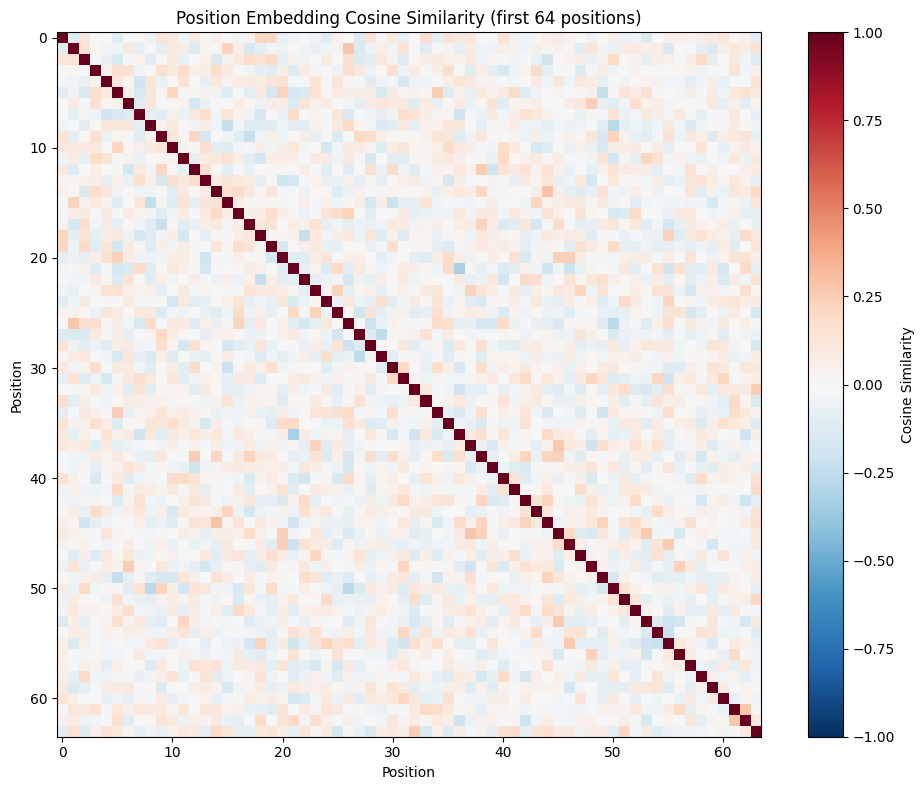

If nearby positions are similar (warm diagonal band), the model learned
that 'position 10' is more like 'position 11' than 'position 50'.


In [17]:
# Visualize position embedding similarity matrix
# (For first 64 positions to keep it readable)

n_show = 64
pos_subset = pos_emb[:n_show]

# Compute pairwise cosine similarities
norms = norm(pos_subset, axis=1, keepdims=True)
pos_normalized = pos_subset / norms
similarity_matrix = pos_normalized @ pos_normalized.T

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(similarity_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xlabel('Position')
ax.set_ylabel('Position')
ax.set_title(f'Position Embedding Cosine Similarity (first {n_show} positions)')
plt.colorbar(im, ax=ax, label='Cosine Similarity')
plt.tight_layout()
plt.savefig('02_position_similarity.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("If nearby positions are similar (warm diagonal band), the model learned")
print("that 'position 10' is more like 'position 11' than 'position 50'.")

---

## Summary

### What Positional Encoding Added:
- The model now knows *where* each token is, not just *what* it is
- "The girl saw the dog" ≠ "The dog saw the girl" (maybe!)
- Position 7 after "named" can learn to expect names

### What It Still Can't Do:
- Tokens can't *see* each other—they're averaged, not compared
- No "if the previous word was X, then Y is likely"
- Position helps, but context requires attention

### The Lesson:
**Position is necessary but not sufficient. Tokens need to communicate.**

In notebook 03, we add a feedforward layer—per-token "thinking." Still no communication, but more capacity per position.

In notebook 04, we add attention—**tokens finally see each other.**

In [18]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'max_seq_len': MAX_SEQ_LEN,
    'history': history,
}

torch.save(checkpoint, '02_positional.pt')
print("Model saved to 02_positional.pt")

Model saved to 02_positional.pt


In [19]:
print("=" * 60)
print("NOTEBOOK 02 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: Token Embed + Position Embed → Average → Unembed")
print(f"Parameters: {num_params:,}")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print(f"")
print(f"The amoeba now knows where it is.")
print(f"But it still can't see its neighbors.")
print(f"Next: Add some per-token thinking (feedforward layer).")

NOTEBOOK 02 COMPLETE

Architecture: Token Embed + Position Embed → Average → Unembed
Parameters: 1,085,440
Final perplexity: 271.3

The amoeba now knows where it is.
But it still can't see its neighbors.
Next: Add some per-token thinking (feedforward layer).
